In [21]:
#0: imports

import uproot 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from imports.data import CCV1
from torch_geometric.data import DataLoader 
from imports.models import Net_SEC, Net_GAT, Net_Trans
from torch_geometric.nn import knn_graph

import numpy as np
import awkward as ak
import time
from imports.Agglomerative import Aggloremative

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [22]:
data_path = '/vols/cms/mm1221/Data/mix/test/raw/test.root' 
data_file = uproot.open(data_path)
LC_x = data_file['clusters']['position_x'].array()
pgid = data_file['simtrackstersCP']['pdgID'].array()
skim_mask = []
for e in LC_x:
    if 1 <= len(e):
        skim_mask.append(True)
    else:
        skim_mask.append(False)
        
pgid = pgid[skim_mask]


In [23]:
data_path = '/vols/cms/mm1221/Data/mix/test/raw/test.root' 
data_file = uproot.open(data_path)
bc_x = data_file['tracksters']['barycenter_x'].array()
pgid1 = data_file['simtrackstersCP']['pdgID'].array()
skim_mask = []
for e in bc_x:
    if 1 <= len(e):
        skim_mask.append(True)
    else:
        skim_mask.append(False)
        
pgid1 = pgid1[skim_mask]


In [24]:
import pandas as pd

df_GAT = pd.read_csv("csvMix/df_GAT_mix_015.csv")
df_SEC = pd.read_csv("csvMix/df_SEC_mix_021.csv")
df_Trans = pd.read_csv("csvMix/df_Trans_mix_0175.csv")
df_MT = pd.read_csv("csvMix/df_TICL_MT.csv")

df_GAT_e = pd.read_csv("csvPion/df_GAT_pi_015.csv")
df_SEC_e = pd.read_csv("csvPion/df_SEC_pi_021.csv")
df_Trans_e = pd.read_csv("csvPion/df_Trans_pi_0175.csv")
df_MT_e = pd.read_csv("csvPion/df_TICL_MT_pion.csv")




In [25]:
df_GAT['pgid'] = df_GAT.apply(lambda row: pgid1[int(row['event_index'])][int(row['cp_id'])], axis=1)
df_SEC['pgid'] = df_SEC.apply(lambda row: pgid1[int(row['event_index'])][int(row['cp_id'])], axis=1)
df_Trans['pgid'] = df_Trans.apply(lambda row: pgid1[int(row['event_index'])][int(row['cp_id'])], axis=1)
df_MT['pgid'] = df_MT.apply(lambda row: pgid[int(row['event_index'])][int(row['cp_id'])], axis=1)


In [20]:
def calculate_metrics(df, model_name):
    import numpy as np
    #df = df[df['pgid'] == 211].copy()
    # ----- Efficiency Calculation -----
    # Filter out rows where 'cp_id' is NaN
    cp_valid = df.dropna(subset=['cp_id']).copy()
    
    # Define the function to check if a CaloParticle (CP) is associated based on shared energy.
    def is_cp_associated(group):
        cp_energy = group['cp_raw_energy'].iloc[0]  # Assumes cp_raw_energy is consistent in the group.
        threshold = 0.5 * cp_energy
        return (group['shared_energy'] >= threshold).any()
    
    # Group over event_index and cp_id to determine association for each CP.
    cp_grouped = cp_valid.groupby(['event_index', 'cp_id'])
    cp_associated = cp_grouped.apply(is_cp_associated)
    
    # Global efficiency values computed over all events/CPs.
    num_associated_cp = cp_associated.sum()
    total_cp = cp_associated.count()
    overall_efficiency = num_associated_cp / total_cp if total_cp > 0 else 0
    
    # --- Per-Event Efficiency Calculation for Standard Deviation ---
    def event_efficiency(event_df):
        # Group by cp_id for the current event.
        cp_grouped_event = event_df.groupby('cp_id')
        associated = cp_grouped_event.apply(is_cp_associated)
        return associated.mean()  # Fraction of CPs associated in this event.
    
    # Compute a Series of efficiency values indexed by event_index.
    event_eff_series = cp_valid.groupby('event_index').apply(event_efficiency)
    efficiency_std = event_eff_series.std()
    
    # ----- Purity Calculation -----
    # Filter out rows where 'trackster_id' is NaN.
    tst_valid = df.dropna(subset=['trackster_id']).copy()
    
    # Group over event_index and trackster_id and consider a Trackster "associated"
    # if its minimum reco_to_sim_score across CPs is below 0.2.
    tst_grouped = tst_valid.groupby(['event_index', 'trackster_id'])
    tst_associated = tst_grouped['reco_to_sim_score'].min() < 0.2
    
    num_associated_tst = tst_associated.sum()
    total_tst = tst_associated.count()
    overall_purity = num_associated_tst / total_tst if total_tst > 0 else 0
    
    # --- Per-Event Purity Calculation for Standard Deviation ---
    def event_purity(event_df):
        # Within the event, group by trackster_id and check if associated.
        trackster_grouped_event = event_df.groupby('trackster_id')
        purity_series = trackster_grouped_event['reco_to_sim_score'].min() < 0.2
        return purity_series.mean()  # Fraction of associated Tracksters in the event.
    
    event_purity_series = tst_valid.groupby('event_index').apply(event_purity)
    purity_std = event_purity_series.std()
    
    # ----- Number Tracksters Ratio Calculation -----
    # Calculate per-event unique counts for CPs and Tracksters.
    unique_cp = cp_valid.groupby('event_index')['cp_id'].nunique()
    unique_tst = tst_valid.groupby('event_index')['trackster_id'].nunique()
    
    # Compute the ratio for each event: (# Tracksters) / (# CPs)
    trackster_ratio_series = unique_tst / unique_cp
    # Replace any NaN (if an event has 0 CP) with 0
    trackster_ratio_series = trackster_ratio_series.fillna(0)
    
    overall_ratio = trackster_ratio_series.mean()
    ratio_std = trackster_ratio_series.std()
    
    # ----- Print Results for the Model -----
    print(f"\nModel: {model_name}")
    print(f"Efficiency:         {overall_efficiency:.4f} (Std Dev: {efficiency_std:.4f})")
    print(f"Purity:             {overall_purity:.4f} (Std Dev: {purity_std:.4f})")
    print(f"Tracksters Ratio:   {overall_ratio:.4f} (Std Dev: {ratio_std:.4f})")
    
    return {
        'efficiency': overall_efficiency,
        'efficiency_std': efficiency_std,
        'purity': overall_purity,
        'purity_std': purity_std,
        'trackster_ratio': overall_ratio,
        'trackster_ratio_std': ratio_std
    }

# Example usage:
our_model_metrics = calculate_metrics(df_GAT_e, "GAT Model")
de_model_metrics = calculate_metrics(df_SEC_e, "DE Model")
trans_model_metrics = calculate_metrics(df_Trans_e, "Transformer Model")
mt_model_metrics = calculate_metrics(df_MT_e, "CERN Mixed Tracksters")



Model: GAT Model
Efficiency:         0.9997 (Std Dev: 0.0218)
Purity:             0.9631 (Std Dev: 0.1099)
Tracksters Ratio:   1.1149 (Std Dev: 0.4337)

Model: DE Model
Efficiency:         0.9993 (Std Dev: 0.0193)
Purity:             0.9624 (Std Dev: 0.1118)
Tracksters Ratio:   1.0860 (Std Dev: 0.3787)

Model: Transformer Model
Efficiency:         0.9997 (Std Dev: 0.0097)
Purity:             0.9774 (Std Dev: 0.0832)
Tracksters Ratio:   1.0606 (Std Dev: 0.3282)

Model: CERN Mixed Tracksters
Efficiency:         0.8738 (Std Dev: 0.2188)
Purity:             0.9841 (Std Dev: 0.0631)
Tracksters Ratio:   1.8175 (Std Dev: 0.8838)


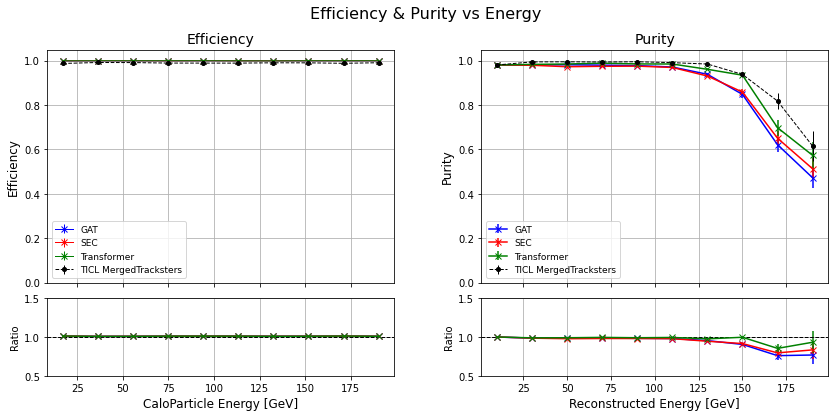

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------------------------------------------------
# 1. Assume the following DataFrames are already loaded:
#    Efficiency DataFrames: df_GAT, df_SEC, df_Trans, df_MT
#    Electron DataFrames:   df_GAT_e, df_SEC_e, df_Trans_e, df_MT_e
# --------------------------------------------------------------------

# --------------------------------------------------------------------
# 2. Prepare data for EFFICIENCY (Mix DataFrames)
# --------------------------------------------------------------------

# Build a dictionary with the new keys.
model_dfs_all = {
    "GAT": df_GAT,
    "SEC": df_SEC,
    "Transformer": df_Trans,
    "TICL MergedTracksters": df_MT
}

# Cast numeric columns and filter for pgid in [211, -211]
for name, df in model_dfs_all.items():
    df['cp_id'] = pd.to_numeric(df['cp_id'], errors='coerce')
    df['shared_energy'] = pd.to_numeric(df['shared_energy'], errors='coerce')
    df['cp_energy'] = pd.to_numeric(df['cp_raw_energy'], errors='coerce')
    df['cp_regressed_energy'] = pd.to_numeric(df['cp_regressed_energy'], errors='coerce')
    model_dfs_all[name] = df[df['pgid'].isin([11, -11])]

def prepare_cp_data(df):
    grouped = df.groupby(['event_index', 'cp_id']).agg({
        'cp_energy': 'first',
        'shared_energy': 'max'
    }).reset_index()
    # Define "reco" if shared energy is at least 50% of the cp energy
    grouped['reco'] = (grouped['shared_energy'] >= 0.5 * grouped['cp_energy']).astype(int)
    return grouped

# Process each efficiency dataframe.
model_prepared_all = {name: prepare_cp_data(df) for name, df in model_dfs_all.items()}

# Define efficiency binning
all_energies = pd.concat([df['cp_energy'] for df in model_prepared_all.values()])
min_energy = all_energies.min()
max_energy = 200
n_bins = 10
energy_bins = np.linspace(min_energy, max_energy, n_bins + 1)
bin_centers = 0.5 * (energy_bins[:-1] + energy_bins[1:])

# Assign energy bins to each dataFrame.
for df in model_prepared_all.values():
    df['energy_bin'] = pd.cut(df['cp_energy'], bins=energy_bins, labels=False, include_lowest=True)

def aggregate_efficiency(df):
    agg = df.groupby('energy_bin').agg(
        total_cp=('cp_energy', 'count'),
        reco_cp=('reco', 'sum')
    ).reset_index()
    agg['efficiency'] = agg['reco_cp'] / agg['total_cp']
    agg['eff_error'] = np.sqrt(agg['efficiency'] * (1 - agg['efficiency']) / agg['total_cp'])
    return agg

# Compute efficiency aggregates for each model.
eff_all = {name: aggregate_efficiency(df) for name, df in model_prepared_all.items()}

# Build final dictionary for efficiency curves.
model_efficiency = {
    "GAT": eff_all["GAT"],
    "SEC": eff_all["SEC"],
    "Transformer": eff_all["Transformer"],
    "TICL MergedTracksters": eff_all["TICL MergedTracksters"]
}

# --------------------------------------------------------------------
# 3. Prepare data for PURITY (Electron/Pion DataFrames)
# --------------------------------------------------------------------
model_dfs_e_all = {
    "GAT": df_GAT_e,
    "SEC": df_SEC_e,
    "Transformer": df_Trans_e,
    "TICL MergedTracksters": df_MT_e
}

def prepare_trackster_data(df):
    df['trackster_id'] = pd.to_numeric(df['trackster_id'], errors='coerce')
    df['reco_to_sim_score'] = pd.to_numeric(df['reco_to_sim_score'], errors='coerce')
    df['trackster_energy'] = pd.to_numeric(df['trackster_energy'], errors='coerce')
    grouped = df.groupby(['event_index', 'trackster_id']).agg({
        'trackster_energy': 'first',
        'reco_to_sim_score': 'min'
    }).reset_index()
    # Define association if the minimum reco-to-sim score is less than 0.2
    grouped['assoc'] = (grouped['reco_to_sim_score'] < 0.2).astype(int)
    return grouped

# Process electron/pion DataFrames.
prepared_dfs_e_all = {name: prepare_trackster_data(df) for name, df in model_dfs_e_all.items()}

# Define purity binning
all_energies_e = pd.concat([df['trackster_energy'] for df in prepared_dfs_e_all.values()])
min_energy_e = all_energies_e.min()
max_energy_e = 200
n_bins_e = 10
energy_bins_e = np.linspace(min_energy_e, max_energy_e, n_bins_e + 1)
bin_centers_e = 0.5 * (energy_bins_e[:-1] + energy_bins_e[1:])

# Assign energy bins for each electron dataframe.
for df in prepared_dfs_e_all.values():
    df['energy_bin'] = pd.cut(df['trackster_energy'], bins=energy_bins_e, labels=False, include_lowest=True)

def aggregate_purity(df):
    agg = df.groupby('energy_bin').agg(
        total_ts=('trackster_energy', 'count'),
        assoc_ts=('assoc', 'sum')
    ).reset_index()
    agg['purity'] = agg['assoc_ts'] / agg['total_ts']
    agg['purity_error'] = np.sqrt(agg['purity'] * (1 - agg['purity']) / agg['total_ts'])
    return agg.set_index('energy_bin').reindex(range(n_bins_e)).reset_index()

# Compute purity aggregates.
pur_all = {name: aggregate_purity(df) for name, df in prepared_dfs_e_all.items()}

# Build final dictionary for purity curves.
model_purity = {
    "GAT": pur_all["GAT"],
    "SEC": pur_all["SEC"],
    "Transformer": pur_all["Transformer"],
    "TICL MergedTracksters": pur_all["TICL MergedTracksters"]
}

# --------------------------------------------------------------------
# 4. Build the figure: Two columns for Efficiency and Purity with
#    top subplots (absolute values) and ratio subplots.
# --------------------------------------------------------------------
fig = plt.figure(figsize=(14, 6))
outer_gs = fig.add_gridspec(nrows=1, ncols=2, wspace=0.25)

# -----------------------
# LEFT COLUMN: Efficiency
# -----------------------
left_gs = outer_gs[0, 0].subgridspec(nrows=2, ncols=1, height_ratios=[3, 1], hspace=0.1)
ax_eff = fig.add_subplot(left_gs[0])
ax_eff_ratio = fig.add_subplot(left_gs[1], sharex=ax_eff)

eff_colors = {
    "GAT": "blue",
    "SEC": "red",
    "Transformer": "green",
    "TICL MergedTracksters": "black"
}

# Plot efficiency curves.
for key, agg in model_efficiency.items():
    if key == "TICL MergedTracksters":
        marker_style = "o"
        linestyle = "--"
        color = eff_colors[key]
        linewidth = 1
        markersize = 4
    else:
        marker_style = "x"
        linestyle = "-"
        color = eff_colors[key]
        linewidth = 1
        markersize = 6
    ax_eff.errorbar(
        bin_centers, agg['efficiency'],
        yerr=agg['eff_error'],
        marker=marker_style, linestyle=linestyle, linewidth=linewidth, markersize=markersize,
        label=key, color=color
    )

ax_eff.tick_params(labelbottom=False)
ax_eff.set_ylabel('Efficiency', fontsize=12)
ax_eff.set_ylim(0, 1.05)
ax_eff.legend(fontsize=9)
ax_eff.grid(True)
ax_eff.set_title('Efficiency', fontsize=14)

# Efficiency ratio plot: (non-reference curves divided by TICL MergedTracksters)
ref_key_eff = "TICL MergedTracksters"
ref_eff = model_efficiency[ref_key_eff]
ref_eff_val = ref_eff['efficiency'].replace(0, np.nan)
ref_eff_err = ref_eff['eff_error']

for key, agg in model_efficiency.items():
    if key == ref_key_eff:
        continue
    marker_style = "x"
    linestyle = "-"
    color = eff_colors[key]
    ratio = agg['efficiency'] / ref_eff_val
    ratio_err = ratio * np.sqrt((agg['eff_error']/agg['efficiency'])**2 + (ref_eff_err/ref_eff_val)**2)
    ax_eff_ratio.errorbar(
        bin_centers, ratio,
        yerr=ratio_err,
        marker=marker_style, linestyle=linestyle, linewidth=1.5, markersize=6,
        color=color
    )

ax_eff_ratio.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax_eff_ratio.set_xlabel('CaloParticle Energy [GeV]', fontsize=12)
ax_eff_ratio.set_ylabel('Ratio', fontsize=10)
ax_eff_ratio.set_ylim(0.5, 1.5)
ax_eff_ratio.grid(True)

# ------------------------
# RIGHT COLUMN: Purity
# ------------------------
right_gs = outer_gs[0, 1].subgridspec(nrows=2, ncols=1, height_ratios=[3, 1], hspace=0.1)
ax_purity = fig.add_subplot(right_gs[0])
ax_purity_ratio = fig.add_subplot(right_gs[1], sharex=ax_purity)

pur_colors = {
    "GAT": "blue",
    "SEC": "red",
    "Transformer": "green",
    "TICL MergedTracksters": "black"
}

# Plot purity curves.
for key, agg in model_purity.items():
    if key == "TICL MergedTracksters":
        marker_style = "o"
        linestyle = "--"
        color = pur_colors[key]
        linewidth = 1
        markersize = 4
    else:
        marker_style = "x"
        linestyle = "-"
        color = pur_colors[key]
        linewidth = 1.5
        markersize = 6
    ax_purity.errorbar(
        bin_centers_e, agg['purity'],
        yerr=agg['purity_error'],
        marker=marker_style, linestyle=linestyle, linewidth=linewidth, markersize=markersize,
        label=key, color=color
    )

ax_purity.tick_params(labelbottom=False)
ax_purity.set_ylabel('Purity', fontsize=12)
ax_purity.set_ylim(0, 1.05)
ax_purity.legend(fontsize=9)
ax_purity.grid(True)
ax_purity.set_title('Purity', fontsize=14)

# Purity ratio plot: (non-reference curves divided by TICL MergedTracksters)
ref_key_pur = "TICL MergedTracksters"
ref_pur = model_purity[ref_key_pur]
ref_pur_val = ref_pur['purity'].replace(0, np.nan)
ref_pur_err = ref_pur['purity_error']

for key, agg in model_purity.items():
    if key == ref_key_pur:
        continue
    marker_style = "x"
    linestyle = "-"
    color = pur_colors[key]
    ratio = agg['purity'] / ref_pur_val
    ratio_err = ratio * np.sqrt((agg['purity_error']/agg['purity'])**2 + (ref_pur_err/ref_pur_val)**2)
    ax_purity_ratio.errorbar(
        bin_centers_e, ratio,
        yerr=ratio_err,
        marker=marker_style, linestyle=linestyle, linewidth=1.5, markersize=6,
        color=color
    )

ax_purity_ratio.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax_purity_ratio.set_xlabel('Reconstructed Energy [GeV]', fontsize=12)
ax_purity_ratio.set_ylabel('Ratio', fontsize=10)
ax_purity_ratio.set_ylim(0.5, 1.5)
ax_purity_ratio.grid(True)

plt.suptitle('Efficiency & Purity vs Energy', fontsize=16)
plt.show()


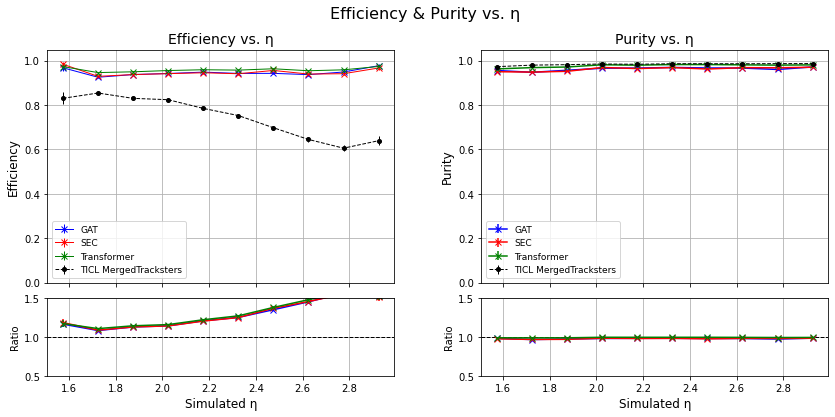

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------------------------------------------------
# 1. Prepare Efficiency vs. η from CaloParticle Data
# --------------------------------------------------------------------
# Build a temporary dictionary of mix DataFrames.
model_dfs_all = {
    "GAT": df_GAT,
    "SEC": df_SEC,
    "Transformer": df_Trans,
    "TICL MergedTracksters": df_MT
}

# Cast numeric columns and filter rows based on pgid in [211, -211]
for name, df in model_dfs_all.items():
    df['cp_id'] = pd.to_numeric(df['cp_id'], errors='coerce')
    df['shared_energy'] = pd.to_numeric(df['shared_energy'], errors='coerce')
    df['cp_energy'] = pd.to_numeric(df['cp_raw_energy'], errors='coerce')
    df['cp_regressed_energy'] = pd.to_numeric(df['cp_regressed_energy'], errors='coerce')
    df['cp_eta'] = pd.to_numeric(df['cp_eta'], errors='coerce')
    model_dfs_all[name] = df[df['pgid'].isin([211, -211])]

# Function to prepare CaloParticle data (including η)
def prepare_cp_data(df):
    grouped = df.groupby(['event_index', 'cp_id']).agg({
        'cp_energy': 'first',
        'cp_eta': 'first',
        'shared_energy': 'max'
    }).reset_index()
    # A CaloParticle is considered reconstructed if its shared_energy 
    # is at least 50% of its cp_energy.
    grouped['reco'] = (grouped['shared_energy'] >= 0.7 * grouped['cp_energy']).astype(int)
    return grouped

# Process all mix data.
model_prepared_all = {name: prepare_cp_data(df) for name, df in model_dfs_all.items()}

# Define η binning from 1.5 to 3.0 in 10 bins (adjust as needed).
min_eta = 1.5
max_eta = 3.0
n_eta_bins = 10
eta_bins = np.linspace(min_eta, max_eta, n_eta_bins + 1)
eta_centers = (eta_bins[:-1] + eta_bins[1:]) / 2

# Assign η bins to each DataFrame.
for df in model_prepared_all.values():
    df['eta_bin'] = pd.cut(df['cp_eta'], bins=eta_bins, labels=False, include_lowest=True)

# Aggregate efficiency versus η.
def aggregate_efficiency_eta(df):
    agg = df.groupby('eta_bin').agg(
        total_cp=('cp_energy', 'count'),
        reco_cp=('reco', 'sum')
    ).reset_index()
    agg['efficiency'] = agg['reco_cp'] / agg['total_cp']
    agg['eff_error'] = np.sqrt(agg['efficiency'] * (1 - agg['efficiency']) / agg['total_cp'])
    return agg

eff_all = {name: aggregate_efficiency_eta(df) for name, df in model_prepared_all.items()}

# Build final efficiency dictionary.
model_efficiency_eta = {
    "GAT": eff_all["GAT"],
    "SEC": eff_all["SEC"],
    "Transformer": eff_all["Transformer"],
    "TICL MergedTracksters": eff_all["TICL MergedTracksters"]
}

# --------------------------------------------------------------------
# 2. Prepare Purity vs. η from Electron Trackster Data
# --------------------------------------------------------------------
# Build a dictionary with the electron trackster DataFrames.
model_dfs_e_all = {
    "GAT": df_GAT_e,
    "SEC": df_SEC_e,
    "Transformer": df_Trans_e,
    "TICL MergedTracksters": df_MT_e
}

# Assume each electron trackster file provides a measurement of cp_eta.
def prepare_trackster_data_eta(df):
    df['trackster_id'] = pd.to_numeric(df['trackster_id'], errors='coerce')
    df['reco_to_sim_score'] = pd.to_numeric(df['reco_to_sim_score'], errors='coerce')
    df['cp_eta'] = pd.to_numeric(df['cp_eta'], errors='coerce')
    grouped = df.groupby(['event_index', 'trackster_id']).agg({
        'cp_eta': 'first',
        'reco_to_sim_score': 'min'
    }).reset_index()
    # For purity, define "associated" if the reco_to_sim_score is below 0.2.
    grouped['assoc'] = (grouped['reco_to_sim_score'] < 0.2).astype(int)
    return grouped

# Process electron data.
model_prepared_e = {name: prepare_trackster_data_eta(df) for name, df in model_dfs_e_all.items()}

# Assign the same η bins as above.
for df in model_prepared_e.values():
    df['eta_bin'] = pd.cut(df['cp_eta'], bins=eta_bins, labels=False, include_lowest=True)

# Aggregate purity versus η.
def aggregate_purity_eta(df):
    agg = df.groupby('eta_bin').agg(
        total_ts=('cp_eta', 'count'),
        assoc_ts=('assoc', 'sum')
    ).reset_index()
    agg['purity'] = agg['assoc_ts'] / agg['total_ts']
    agg['purity_error'] = np.sqrt(agg['purity'] * (1 - agg['purity']) / agg['total_ts'])
    return agg

pur_all_eta = {name: aggregate_purity_eta(df) for name, df in model_prepared_e.items()}

# Build final purity dictionary.
model_purity_eta = {
    "GAT": pur_all_eta["GAT"],
    "SEC": pur_all_eta["SEC"],
    "Transformer": pur_all_eta["Transformer"],
    "TICL MergedTracksters": pur_all_eta["TICL MergedTracksters"]
}

# --------------------------------------------------------------------
# 3. Build the Figure: Efficiency and Purity vs. η (side by side)
# --------------------------------------------------------------------
fig = plt.figure(figsize=(14, 6))
# Create two columns: left for efficiency and right for purity.
outer_gs = fig.add_gridspec(nrows=1, ncols=2, wspace=0.25)

# ----- Left Column: Efficiency vs. η -----
eff_gs = outer_gs[0, 0].subgridspec(nrows=2, ncols=1, height_ratios=[3, 1], hspace=0.1)
ax_eff = fig.add_subplot(eff_gs[0])
ax_eff_ratio = fig.add_subplot(eff_gs[1], sharex=ax_eff)

# Define colors and marker styles for efficiency.
eff_colors = {
    "GAT": "blue",
    "SEC": "red",
    "Transformer": "green",
    "TICL MergedTracksters": "black"
}

for key, agg in model_efficiency_eta.items():
    if key == "TICL MergedTracksters":
        marker_style = "o"
        linestyle = "--"
        linewidth = 1
        markersize = 4
        color = eff_colors[key]
    else:
        marker_style = "x"
        linestyle = "-"
        linewidth = 1
        markersize = 6
        color = eff_colors[key]
    ax_eff.errorbar(
        eta_centers, agg['efficiency'],
        yerr=agg['eff_error'],
        marker=marker_style, linestyle=linestyle, linewidth=linewidth, markersize=markersize,
        label=key, color=color
    )

# Remove x-axis tick labels from the top efficiency plot.
ax_eff.tick_params(labelbottom=False)
ax_eff.set_ylabel('Efficiency', fontsize=12)
ax_eff.set_ylim(0, 1.05)
ax_eff.legend(fontsize=9)
ax_eff.grid(True)
ax_eff.set_title('Efficiency vs. η', fontsize=14)

# Efficiency ratio: each curve divided by TICL MergedTracksters.
ref_key_eff = "TICL MergedTracksters"
ref_eff = model_efficiency_eta[ref_key_eff]
ref_val_eff = ref_eff['efficiency'].replace(0, np.nan)
ref_err_eff = ref_eff['eff_error']

for key, agg in model_efficiency_eta.items():
    if key == ref_key_eff:
        continue
    marker_style = "x"
    linestyle = "-"
    linewidth = 1.5
    markersize = 6
    color = eff_colors[key]
    ratio = agg['efficiency'] / ref_val_eff
    ratio_err = ratio * np.sqrt((agg['eff_error'] / agg['efficiency'])**2 + (ref_err_eff / ref_val_eff)**2)
    ax_eff_ratio.errorbar(
        eta_centers, ratio,
        yerr=ratio_err,
        marker=marker_style, linestyle=linestyle, linewidth=linewidth, markersize=markersize,
        color=color
    )

ax_eff_ratio.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax_eff_ratio.set_xlabel('Simulated η', fontsize=12)
ax_eff_ratio.set_ylabel('Ratio', fontsize=10)
ax_eff_ratio.set_ylim(0.5, 1.5)
ax_eff_ratio.grid(True)

# ----- Right Column: Purity vs. η -----
pur_gs = outer_gs[0, 1].subgridspec(nrows=2, ncols=1, height_ratios=[3, 1], hspace=0.1)
ax_pur = fig.add_subplot(pur_gs[0])
ax_pur_ratio = fig.add_subplot(pur_gs[1], sharex=ax_pur)

# Define colors and marker styles for purity.
pur_colors = {
    "GAT": "blue",
    "SEC": "red",
    "Transformer": "green",
    "TICL MergedTracksters": "black"
}

for key, agg in model_purity_eta.items():
    if key == "TICL MergedTracksters":
        marker_style = "o"
        linestyle = "--"
        linewidth = 1
        markersize = 4
        color = pur_colors[key]
    else:
        marker_style = "x"
        linestyle = "-"
        linewidth = 1.5
        markersize = 6
        color = pur_colors[key]
    ax_pur.errorbar(
        eta_centers, agg['purity'],
        yerr=agg['purity_error'],
        marker=marker_style, linestyle=linestyle, linewidth=linewidth, markersize=markersize,
        label=key, color=color
    )

ax_pur.tick_params(labelbottom=False)
ax_pur.set_ylabel('Purity', fontsize=12)
ax_pur.set_ylim(0, 1.05)
ax_pur.legend(fontsize=9)
ax_pur.grid(True)
ax_pur.set_title('Purity vs. η', fontsize=14)

# Purity ratio: each curve divided by TICL MergedTracksters.
ref_key_pur = "TICL MergedTracksters"
ref_pur = model_purity_eta[ref_key_pur]
ref_val_pur = ref_pur['purity'].replace(0, np.nan)
ref_err_pur = ref_pur['purity_error']

for key, agg in model_purity_eta.items():
    if key == ref_key_pur:
        continue
    marker_style = "x"
    linestyle = "-"
    linewidth = 1.5
    markersize = 6
    color = pur_colors[key]
    ratio = agg['purity'] / ref_val_pur
    ratio_err = ratio * np.sqrt((agg['purity_error'] / agg['purity'])**2 + (ref_err_pur / ref_val_pur)**2)
    ax_pur_ratio.errorbar(
        eta_centers, ratio,
        yerr=ratio_err,
        marker=marker_style, linestyle=linestyle, linewidth=linewidth, markersize=markersize,
        color=color
    )

ax_pur_ratio.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax_pur_ratio.set_xlabel('Simulated η', fontsize=12)
ax_pur_ratio.set_ylabel('Ratio', fontsize=10)
ax_pur_ratio.set_ylim(0.5, 1.5)
ax_pur_ratio.grid(True)

plt.suptitle('Efficiency & Purity vs. η', fontsize=16)
plt.show()


/tmp/ipykernel_2716968/801230810.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_cp'] = df.groupby('event_index')['cp_id'].transform('nunique')
/tmp/ipykernel_2716968/801230810.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_cp'] = df.groupby('event_index')['cp_id'].transform('nunique')
/tmp/ipykernel_2716968/801230810.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

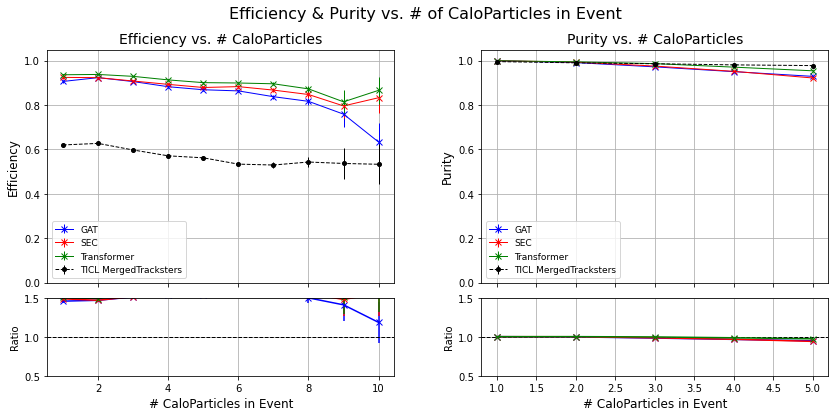

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------------------------------------------------
# 1. Load DataFrames (for Efficiency)
# --------------------------------------------------------------------
# Assume these DataFrames are already loaded in your workspace:
# df_GAT, df_SEC, df_Trans, df_MT

# --------------------------------------------------------------------
# 2. Load DataFrames (for Purity)
# --------------------------------------------------------------------
# Assume these DataFrames are already loaded in your workspace:
# df_GAT_e, df_SEC_e, df_Trans_e, df_MT_e

# --------------------------------------------------------------------
# 3. Prepare Efficiency vs. # of CaloParticles in the event
# --------------------------------------------------------------------
# Build a dictionary with all keys; note that we drop any "CERN Tracksters" entry.
model_dfs_all = {
    "GAT": df_GAT,
    "SEC": df_SEC,            # will be renamed to "DEC" in the final dictionary
    "Transformer": df_Trans,
    "CERN Mixed Tracksters": df_MT
}

# Cast columns to numeric and filter for pgid in [211, -211]. (Adjust the values if needed.)
for name, df in model_dfs_all.items():
    df['event_index'] = pd.to_numeric(df['event_index'], errors='coerce')
    df['cp_id'] = pd.to_numeric(df['cp_id'], errors='coerce')
    df['shared_energy'] = pd.to_numeric(df['shared_energy'], errors='coerce')
    df['cp_energy'] = pd.to_numeric(df['cp_raw_energy'], errors='coerce')
    df['cp_regressed_energy'] = pd.to_numeric(df['cp_regressed_energy'], errors='coerce')
    # Filter for pgid in [211, -211] (even though the comment mentions ±11, we follow the provided code)
    df = df[df['pgid'].isin([211, -211])]
    
    # For each event, add a column with the number of unique cp_id's
    df['n_cp'] = df.groupby('event_index')['cp_id'].transform('nunique')
    
    # Group by (event_index, cp_id) to get one row per CaloParticle along with the event's CP count
    grouped = df.groupby(['event_index', 'cp_id']).agg({
        'cp_energy': 'first',
        'shared_energy': 'max',
        'n_cp': 'first'
    }).reset_index()
    
    # Mark whether this CaloParticle was reconstructed (shared_energy at least 50% of cp_energy)
    grouped['reco'] = (grouped['shared_energy'] >= 0.8 * grouped['cp_energy']).astype(int)
    
    model_dfs_all[name] = grouped

# Function to aggregate efficiency vs. number of CaloParticles (n_cp)
def aggregate_efficiency_ncp(df):
    agg = df.groupby('n_cp').agg(
        total_cp=('cp_id', 'count'),
        reco_cp=('reco', 'sum')
    ).reset_index()
    agg['efficiency'] = agg['reco_cp'] / agg['total_cp']
    agg['eff_error'] = np.sqrt(agg['efficiency'] * (1 - agg['efficiency']) / agg['total_cp'])
    return agg

eff_all = {name: aggregate_efficiency_ncp(df) for name, df in model_dfs_all.items()}

# Build the final efficiency dictionary:
# Rename "SEC" to "DEC" and "CERN Mixed Tracksters" to "TICL MergedTracksters"
model_efficiency_ncp = {
    "GAT": eff_all["GAT"],
    "SEC": eff_all["SEC"],
    "Transformer": eff_all["Transformer"],
    "TICL MergedTracksters": eff_all["CERN Mixed Tracksters"]
}

# --------------------------------------------------------------------
# 4. Prepare Purity vs. # of CaloParticles in the event (from Electron Trackster Data)
# --------------------------------------------------------------------
model_dfs_e_all = {
    "GAT": df_GAT_e,
    "SEC": df_SEC_e,             # will be renamed to "DEC"
    "Transformer": df_Trans_e,
    "CERN Mixed Tracksters": df_MT_e
}

def prepare_trackster_data_ncp(df):
    df['event_index'] = pd.to_numeric(df['event_index'], errors='coerce')
    df['trackster_id'] = pd.to_numeric(df['trackster_id'], errors='coerce')
    df['reco_to_sim_score'] = pd.to_numeric(df['reco_to_sim_score'], errors='coerce')
    df['cp_id'] = pd.to_numeric(df['cp_id'], errors='coerce')
    
    # For each event, add the number of unique cp_id's
    df['n_cp'] = df.groupby('event_index')['cp_id'].transform('nunique')
    
    # Group by (event_index, trackster_id) to later define the association
    grouped = df.groupby(['event_index', 'trackster_id']).agg({
        'reco_to_sim_score': 'min',
        'n_cp': 'first'
    }).reset_index()
    
    # Define "associated" as having reco_to_sim_score < 0.2
    grouped['assoc'] = (grouped['reco_to_sim_score'] < 0.2).astype(int)
    return grouped

model_prepared_e_all = {name: prepare_trackster_data_ncp(df) for name, df in model_dfs_e_all.items()}

def aggregate_purity_ncp(df):
    agg = df.groupby('n_cp').agg(
        total_ts=('trackster_id', 'count'),
        assoc_ts=('assoc', 'sum')
    ).reset_index()
    agg['purity'] = agg['assoc_ts'] / agg['total_ts']
    agg['purity_error'] = np.sqrt(agg['purity'] * (1 - agg['purity']) / agg['total_ts'])
    return agg

pur_all = {name: aggregate_purity_ncp(df) for name, df in model_prepared_e_all.items()}

model_purity_ncp = {
    "GAT": pur_all["GAT"],
    "SEC": pur_all["SEC"],
    "Transformer": pur_all["Transformer"],
    "TICL MergedTracksters": pur_all["CERN Mixed Tracksters"]
}

# --------------------------------------------------------------------
# 5. Build the Figure: Efficiency and Purity vs. Number of CaloParticles in Event
# --------------------------------------------------------------------
fig = plt.figure(figsize=(14, 6))
outer_gs = fig.add_gridspec(nrows=1, ncols=2, wspace=0.25)

# ----- Left Column: Efficiency vs n_cp -----
eff_gs = outer_gs[0, 0].subgridspec(nrows=2, ncols=1, height_ratios=[3, 1], hspace=0.1)
ax_eff = fig.add_subplot(eff_gs[0])
ax_eff_ratio = fig.add_subplot(eff_gs[1], sharex=ax_eff)

# Define colors and marker styles.
eff_colors = {
    "GAT": "blue",
    "SEC": "red",
    "Transformer": "green",
    "TICL MergedTracksters": "black"
}

# Plot efficiency vs. n_cp for each model.
for key, df_agg in model_efficiency_ncp.items():
    df_agg_sorted = df_agg.sort_values('n_cp')
    xvals = df_agg_sorted['n_cp']
    yvals = df_agg_sorted['efficiency']
    yerr  = df_agg_sorted['eff_error']
    
    if key == "TICL MergedTracksters":
        marker_style = "o"
        ls = "--"
        color = eff_colors[key]
        lw = 1
        ms = 4
    else:
        marker_style = "x"
        ls = "-"
        color = eff_colors[key]
        lw = 1
        ms = 6
        
    ax_eff.errorbar(xvals, yvals, yerr=yerr,
                    marker=marker_style, linestyle=ls, linewidth=lw, markersize=ms,
                    label=key, color=color)

ax_eff.tick_params(labelbottom=False)
ax_eff.set_ylabel('Efficiency', fontsize=12)
ax_eff.set_ylim(0, 1.05)
ax_eff.legend(fontsize=9)
ax_eff.grid(True)
ax_eff.set_title('Efficiency vs. # CaloParticles', fontsize=14)

# Efficiency Ratio Plot:
ref_key_eff = "TICL MergedTracksters"
ref_df_eff = model_efficiency_ncp[ref_key_eff].sort_values('n_cp')
for key, df_agg in model_efficiency_ncp.items():
    if key == ref_key_eff:
        continue
    df_agg_sorted = df_agg.sort_values('n_cp')
    merged = pd.merge(df_agg_sorted, ref_df_eff, on='n_cp', suffixes=('', '_ref'))
    xvals  = merged['n_cp']
    num_val  = merged['efficiency']
    num_err  = merged['eff_error']
    den_val  = merged['efficiency_ref'].replace(0, np.nan)
    den_err  = merged['eff_error_ref']
    
    ratio = num_val / den_val
    ratio_err = ratio * np.sqrt((num_err/num_val)**2 + (den_err/den_val)**2)
    
    marker_style = "x"
    ls = "-"
    color = eff_colors[key]
    lw = 1.5
    ms = 6
    
    ax_eff_ratio.errorbar(xvals, ratio, yerr=ratio_err,
                          marker=marker_style, linestyle=ls, linewidth=lw, markersize=ms,
                          color=color)

ax_eff_ratio.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax_eff_ratio.set_xlabel('# CaloParticles in Event', fontsize=12)
ax_eff_ratio.set_ylabel('Ratio', fontsize=10)
ax_eff_ratio.set_ylim(0.5, 1.5)
ax_eff_ratio.grid(True)

# ----- Right Column: Purity vs n_cp -----
pur_gs = outer_gs[0, 1].subgridspec(nrows=2, ncols=1, height_ratios=[3, 1], hspace=0.1)
ax_pur = fig.add_subplot(pur_gs[0])
ax_pur_ratio = fig.add_subplot(pur_gs[1], sharex=ax_pur)

pur_colors = {
    "GAT": "blue",
    "SEC": "red",
    "Transformer": "green",
    "TICL MergedTracksters": "black"
}

for key, df_agg in model_purity_ncp.items():
    df_agg_sorted = df_agg.sort_values('n_cp')
    xvals = df_agg_sorted['n_cp']
    yvals = df_agg_sorted['purity']
    yerr  = df_agg_sorted['purity_error']
    
    if key == "TICL MergedTracksters":
        marker_style = "o"
        ls = "--"
        color = pur_colors[key]
        lw = 1
        ms = 4
    else:
        marker_style = "x"
        ls = "-"
        color = pur_colors[key]
        lw = 1
        ms = 6
        
    ax_pur.errorbar(xvals, yvals, yerr=yerr,
                    marker=marker_style, linestyle=ls, linewidth=lw, markersize=ms,
                    label=key, color=color)

ax_pur.tick_params(labelbottom=False)
ax_pur.set_ylabel('Purity', fontsize=12)
ax_pur.set_ylim(0, 1.05)
ax_pur.legend(fontsize=9)
ax_pur.grid(True)
ax_pur.set_title('Purity vs. # CaloParticles', fontsize=14)

# Purity Ratio Plot:
ref_key_pur = "TICL MergedTracksters"
ref_df_pur = model_purity_ncp[ref_key_pur].sort_values('n_cp')
for key, df_agg in model_purity_ncp.items():
    if key == ref_key_pur:
        continue
    df_agg_sorted = df_agg.sort_values('n_cp')
    merged = pd.merge(df_agg_sorted, ref_df_pur, on='n_cp', suffixes=('', '_ref'))
    xvals  = merged['n_cp']
    num_val  = merged['purity']
    num_err  = merged['purity_error']
    den_val  = merged['purity_ref'].replace(0, np.nan)
    den_err  = merged['purity_error_ref']
    
    ratio = num_val / den_val
    ratio_err = ratio * np.sqrt((num_err/num_val)**2 + (den_err/den_val)**2)
    
    marker_style = "x"
    ls = "-"
    color = pur_colors[key]
    lw = 1.5
    ms = 6
    
    ax_pur_ratio.errorbar(xvals, ratio, yerr=ratio_err,
                          marker=marker_style, linestyle=ls, linewidth=lw, markersize=ms,
                          color=color)

ax_pur_ratio.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax_pur_ratio.set_xlabel('# CaloParticles in Event', fontsize=12)
ax_pur_ratio.set_ylabel('Ratio', fontsize=10)
ax_pur_ratio.set_ylim(0.5, 1.5)
ax_pur_ratio.grid(True)

plt.suptitle('Efficiency & Purity vs. # of CaloParticles in Event', fontsize=16)
plt.show()
